# Stats Benchmark — Execution Time Evaluation

This notebook evaluates three result files produced by the **Stats** workload:

- **native**: PostgreSQL's native planner/executor (baseline)
- **standard**: PostBOUND textbook pipeline without pruning
- **pruning**: PostBOUND textbook pipeline **with** pruning

There are **142** queries (labels `q-1` …) in these CSVs (a subset of the original 146), as already documented in the thesis.  
The target metric is **`exec_time`** (seconds).

In [1]:
# Imports
import math
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline
BLUE = "tab:blue"  


# 1. Load the CSV files

In [2]:
native_path   = Path("native_stats_results.csv")
standard_path = Path("standard_stats_results.csv")
pruning_path  = Path("pruning_stats_results.csv")

native_df   = pd.read_csv(native_path)
standard_df = pd.read_csv(standard_path)
pruning_df  = pd.read_csv(pruning_path)

native_df.head(2)

,Unnamed: 0,label,execution_index,query,workload_iteration,query_repetition,exec_time,query_result
0,0,q-1,1,"SELECT COUNT(*) FROM badges AS b, users AS u W...",1,1,0.020543,79851
1,1,q-2,2,"SELECT COUNT(*) FROM comments AS c, badges AS ...",1,1,0.133910,10220614


### Quick check for correctness in the CSV files 

* no duplicates
* correct numbers of columns and unique labeling

In [3]:
def describe_df(df, name):
    print(f"== {name} ==")
    print("shape:", df.shape)
    print("columns:", list(df.columns))
    if "label" in df.columns:
        vc = df["label"].value_counts()
        dups = int((vc[vc > 1] - 1).sum())
        print("unique labels:", df["label"].nunique())
        print("duplicate rows (over labels):", dups)
    print()

describe_df(native_df, "native")
describe_df(standard_df, "standard")
describe_df(pruning_df, "pruning")

== native ==
shape: (142, 8)
columns: ['Unnamed: 0', 'label', 'execution_index', 'query', 'workload_iteration', 'query_repetition', 'exec_time', 'query_result']
unique labels: 142
duplicate rows (over labels): 0

== standard ==
shape: (142, 14)
columns: ['Unnamed: 0', 'label', 'execution_index', 'query', 'workload_iteration', 'query_repetition', 'optimization_time', 'exec_time', 'query_result', 'optimization_success', 'optimization_failure_reason', 'original_query', 'optimization_settings', 'db_config']
unique labels: 142
duplicate rows (over labels): 0

== pruning ==
shape: (142, 14)
columns: ['Unnamed: 0', 'label', 'execution_index', 'query', 'workload_iteration', 'query_repetition', 'optimization_time', 'exec_time', 'query_result', 'optimization_success', 'optimization_failure_reason', 'original_query', 'optimization_settings', 'db_config']
unique labels: 142
duplicate rows (over labels): 0



# 2. Create unified table for analysis

Alignment of the three results based on the label of the queries (inner join)

In [4]:
# Keep only the relevant columns
def pick_columns(df, cols):
    present = [c for c in cols if c in df.columns]
    return df[present].copy()

native_s   = pick_columns(native_df,   ["label", "exec_time"])
standard_s = pick_columns(standard_df, ["label", "exec_time"])
pruning_s  = pick_columns(pruning_df,  ["label", "exec_time"])

# Rename exec_time columns to identify the source
native_s   = native_s.rename(columns={"exec_time": "exec_time_native"})
standard_s = standard_s.rename(columns={"exec_time": "exec_time_standard"})
pruning_s  = pruning_s.rename(columns={"exec_time": "exec_time_pruning"})

# Inner-join step by step to ensure only common labels remain
merged = native_s.merge(standard_s, on="label", how="inner").merge(pruning_s, on="label", how="inner")

print("Merged shape:", merged.shape)
merged.head(3)

Merged shape: (142, 4)


,label,exec_time_native,exec_time_standard,exec_time_pruning
0,q-1,0.020543,0.013869,0.013409
1,q-2,0.133910,0.159026,0.162348
2,q-3,0.126743,0.053652,0.052140


# 3. Compute median results 

Since there is one row per label we can compute the median execution time for each strategy 

In [5]:
medians = pd.DataFrame({
    "approach": ["NATIVE", "STANDARD", "PRUNING"],
    "median_exec_time_s": [
        merged["exec_time_native"].median(),
        merged["exec_time_standard"].median(),
        merged["exec_time_pruning"].median(),
    ]
})
medians

,approach,median_exec_time_s
0,NATIVE,0.105456
1,STANDARD,0.083840
2,PRUNING,0.084380


A simple bar chart to compare these results:

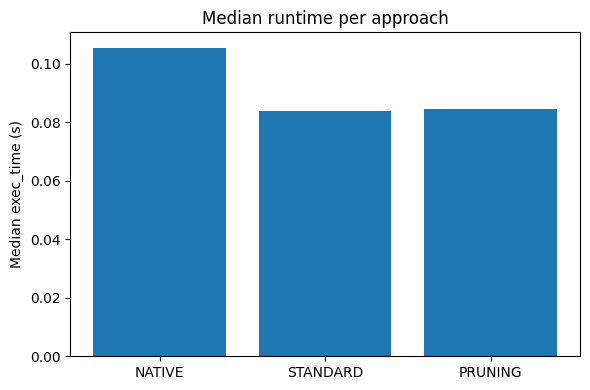

In [6]:
plt.figure(figsize=(6,4))
plt.bar(medians["approach"], medians["median_exec_time_s"], color=BLUE)
plt.ylabel("Median exec_time (s)")
plt.title("Median runtime per approach")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Per query ratios (speedup/slowdown)

Comparing the per-query ratios against each other. A ratio *s < 1.0* is in favor of the first approach in the numerator.

* `STANDARD / NATIVE`
* `PRUNING / NATIVE`
* `PRUNING / STANDARD`

Also taking a look at: 

* `count` (number of queries)
* `median`
* `geometric mean` (mult. average; robust for ratios)
* `p95` (95th percentile)
* `share of wins` (ratio < 0.99) and `share of losses` (ratio > 1.01)

`< 1` → improvement (speedup), `> 1` → regression (slowdown).

In [ ]:
# Compute ratios
merged["ratio_std_native"] = merged["exec_time_standard"] / merged["exec_time_native"]
merged["ratio_prune_native"] = merged["exec_time_pruning"] / merged["exec_time_native"]
merged["ratio_prune_std"] = merged["exec_time_pruning"] / merged["exec_time_standard"]

def geom_mean(x):
    x = np.asarray(x, dtype=float)
    # Filter non-positive 
    x = x[x > 0]
    if len(x) == 0:
        return np.nan
    return float(np.exp(np.log(x).mean()))

def summarize_ratio(series):
    s = pd.Series(series.dropna().values, dtype=float)
    return pd.Series({
        "count": int(s.size),
        "median_ratios": float(s.median()),
        "geometric_mean": geom_mean(s),
        "p95": float(s.quantile(0.95)),
        "share_wins_<0.99": float((s < 0.99).mean()),
        "share_losses_>1.01": float((s > 1.01).mean()),
    })

ratio_summary = pd.DataFrame({
    "STANDARD/NATIVE": summarize_ratio(merged["ratio_std_native"]),
    "PRUNING/NATIVE": summarize_ratio(merged["ratio_prune_native"]),
    "PRUNING/STANDARD": summarize_ratio(merged["ratio_prune_std"]),
}).T

ratio_summary

,count,median_ratios,geometric_mean,p95,share_wins_<0.99,share_losses_>1.01
STANDARD/NATIVE,142.0,0.947103,0.838704,2.537373,0.549296,0.422535
PRUNING/NATIVE,142.0,0.954495,0.847907,2.594201,0.570423,0.422535
PRUNING/STANDARD,142.0,1.003835,1.010973,1.117890,0.302817,0.450704


##### Vizualization of the distribution of each set of ratios. Making tails visible. All values left of *1.0* are an improvement

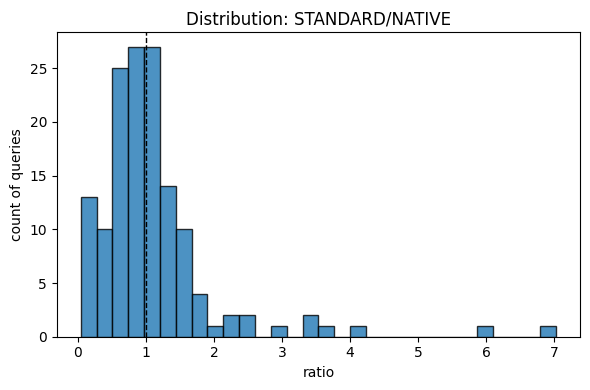

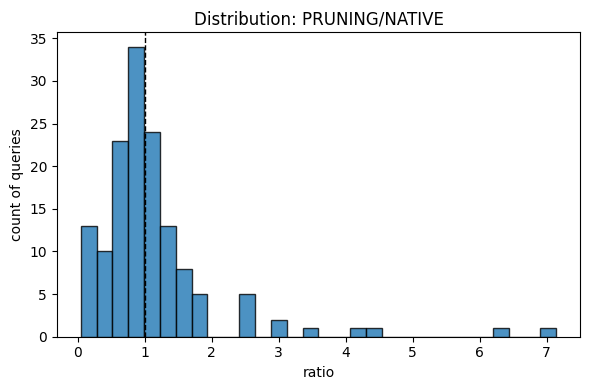

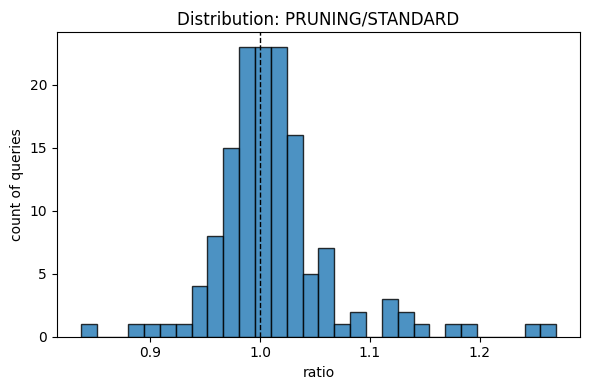

In [9]:
def plot_hist(series, title, bins=30):
    s = pd.Series(series.dropna().values, dtype=float)
    plt.figure(figsize=(6,4))
    plt.hist(s, bins=bins, color=BLUE, edgecolor="black", alpha=0.8)
    plt.axvline(1.0, color="black", linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("ratio")
    plt.ylabel("count of queries")
    plt.tight_layout()
    plt.show()

plot_hist(merged["ratio_std_native"], "Distribution: STANDARD/NATIVE")
plot_hist(merged["ratio_prune_native"], "Distribution: PRUNING/NATIVE")
plot_hist(merged["ratio_prune_std"], "Distribution: PRUNING/STANDARD")


# 5. Tail Stats

Check whether there is a *tail* of regressions by inspecting high-percentile values (e.g., p95/p99/max) and counts above thresholds like `> 1.5×`, `> 2×`.

In [10]:
def tail_stats(series, name):
    s = pd.Series(series.dropna().values, dtype=float)
    print(f"== Tail stats for {name} ==")
    for q in [0.90, 0.95, 0.99]:
        print(f"p{int(q*100):2d}:", float(s.quantile(q)))
    print("max:", float(s.max()))
    for thr in [1.01, 1.1, 1.25, 1.5, 2.0, 3.0]:
        print(f"share > {thr:>4}:", float((s > thr).mean()))
    print()

tail_stats(merged["ratio_std_native"], "STANDARD/NATIVE")
tail_stats(merged["ratio_prune_native"], "PRUNING/NATIVE")
tail_stats(merged["ratio_prune_std"], "PRUNING/STANDARD")

== Tail stats for STANDARD/NATIVE ==
p90: 1.7827081140741692
p95: 2.53737266807542
p99: 5.250114287082109
max: 7.032340580365227
share > 1.01: 0.4225352112676056
share >  1.1: 0.352112676056338
share > 1.25: 0.2535211267605634
share >  1.5: 0.16901408450704225
share >  2.0: 0.07746478873239436
share >  3.0: 0.04225352112676056

== Tail stats for PRUNING/NATIVE ==
p90: 1.7289544431712378
p95: 2.5942009505281276
p99: 5.488965586469268
max: 7.142338149949603
share > 1.01: 0.4225352112676056
share >  1.1: 0.3591549295774648
share > 1.25: 0.24647887323943662
share >  1.5: 0.16901408450704225
share >  2.0: 0.08450704225352113
share >  3.0: 0.04929577464788732

== Tail stats for PRUNING/STANDARD ==
p90: 1.062960750124259
p95: 1.1178895201724155
p99: 1.2271644097188223
max: 1.2694738913723393
share > 1.01: 0.4507042253521127
share >  1.1: 0.07042253521126761
share > 1.25: 0.014084507042253521
share >  1.5: 0.0
share >  2.0: 0.0
share >  3.0: 0.0



An ECDF (empirical cumulative distribution function) gives a compact view of the entire distribution and helps visually inspect tails.

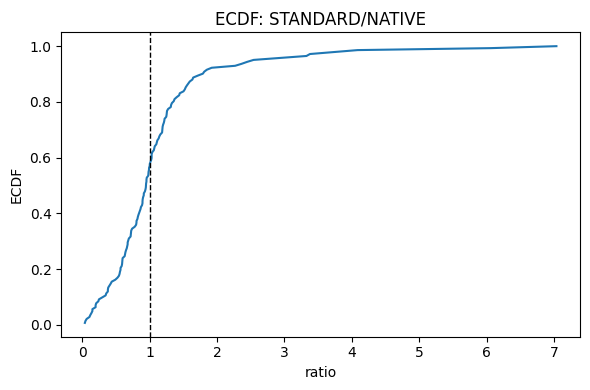

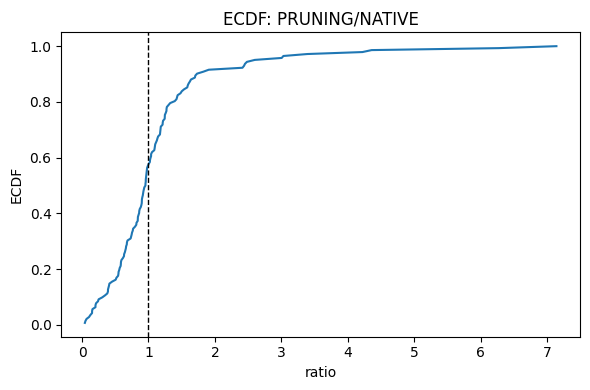

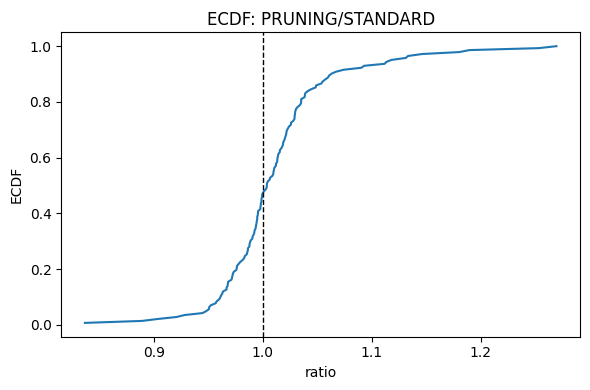

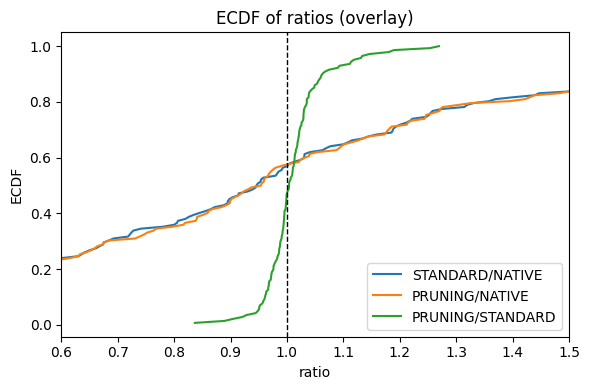

In [ ]:
def plot_ecdf(series, title):
    s = np.sort(series.dropna().values.astype(float))
    y = np.arange(1, len(s)+1) / len(s)
    plt.figure(figsize=(6,4))
    plt.plot(s, y, color=BLUE)
    plt.axvline(1.0, color="black", linestyle="--", linewidth=1)
    plt.xlabel("ratio")
    plt.ylabel("ECDF")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_ecdf(merged["ratio_std_native"], "ECDF: STANDARD/NATIVE")
plot_ecdf(merged["ratio_prune_native"], "ECDF: PRUNING/NATIVE")
plot_ecdf(merged["ratio_prune_std"], "ECDF: PRUNING/STANDARD")

def plot_ecdf_overlay(series_map, title="ECDF (overlay)"):
    import numpy as np
    import matplotlib.pyplot as plt

    colors = ["tab:blue", "tab:orange", "tab:green"]  
    plt.figure(figsize=(6,4))
    for (name, series), c in zip(series_map.items(), colors):
        s = np.sort(series.dropna().values.astype(float))
        y = np.arange(1, len(s)+1) / len(s)
        plt.plot(s, y, linestyle="-", color=c, label=name)

    plt.axvline(1.0, color="black", linestyle="--", linewidth=1)
    plt.xlabel("ratio")
    plt.ylabel("ECDF")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.xlim(0.6, 1.5)
    plt.tight_layout()
    plt.show()

plot_ecdf_overlay({
    "STANDARD/NATIVE":  merged["ratio_std_native"],
    "PRUNING/NATIVE":   merged["ratio_prune_native"],
    "PRUNING/STANDARD": merged["ratio_prune_std"],
}, title="ECDF of ratios (overlay)")

## 6. Top 10 improved & regressed queries

Reporting the *top 10* improvements and regressions for two comparisons:

* `PRUNING vs NATIVE` (ratio `PRUNING/NATIVE`)
* `PRUNING vs STANDARD` (ratio `PRUNING/STANDARD`)

Sorted ascending for improvements and descending for regression


In [12]:

def top_lists(df, ratio_col, k=10):
    cols = ["label", "exec_time_native", "exec_time_standard", "exec_time_pruning", ratio_col]
    small = df[cols].sort_values(ratio_col, ascending=True).head(k).reset_index(drop=True)
    large = df[cols].sort_values(ratio_col, ascending=False).head(k).reset_index(drop=True)
    return small, large

top_imp_pn, top_reg_pn = top_lists(merged, "ratio_prune_native")
top_imp_ps, top_reg_ps = top_lists(merged, "ratio_prune_std")

print("Top 10 improvements (PRUNING vs NATIVE)")
display(top_imp_pn)
print("Top 10 regressions (PRUNING vs NATIVE)")
display(top_reg_pn)

print("Top 10 improvements (PRUNING vs STANDARD)")
display(top_imp_ps)
print("Top 10 regressions (PRUNING vs STANDARD)")
display(top_reg_ps)


Top 10 improvements (PRUNING vs NATIVE)


,label,exec_time_native,exec_time_standard,exec_time_pruning,ratio_prune_native
0,q-131,1.958612,0.078962,0.082200,0.041968
1,q-134,0.894437,0.044303,0.045861,0.051274
2,q-132,0.572226,0.038131,0.038372,0.067058
3,q-50,0.266087,0.028778,0.027977,0.105144
4,q-104,1.740870,0.211020,0.217341,0.124846
5,q-133,2.192729,0.301817,0.329891,0.150448
6,q-106,0.475394,0.072237,0.071693,0.150807
7,q-32,1.798598,0.274349,0.281465,0.156491
8,q-30,11.458978,2.287932,2.310460,0.201629
9,q-143,15.139624,3.023218,3.059909,0.202113


Top 10 regressions (PRUNING vs NATIVE)


,label,exec_time_native,exec_time_standard,exec_time_pruning,ratio_prune_native
0,q-55,0.003551,0.024971,0.025361,7.142338
1,q-52,1.870230,11.332961,11.732748,6.273425
2,q-69,1.047981,4.281166,4.569312,4.360110
3,q-135,23.948398,89.376910,101.109245,4.221963
4,q-67,0.014154,0.047811,0.048029,3.393375
5,q-78,0.029359,0.086430,0.088993,3.031243
6,q-136,3.543319,11.784360,10.650753,3.005870
7,q-63,0.024074,0.054607,0.062595,2.600103
8,q-17,0.005997,0.015247,0.014886,2.482059
9,q-123,1.743770,4.265739,4.277387,2.452954


Top 10 improvements (PRUNING vs STANDARD)


,label,exec_time_native,exec_time_standard,exec_time_pruning,ratio_prune_std
0,q-61,0.089951,0.119726,0.100184,0.836777
1,q-64,0.135872,0.077286,0.068720,0.889167
2,q-136,3.543319,11.784360,10.650753,0.903804
3,q-142,8.539276,5.385940,4.960122,0.920939
4,q-81,0.072911,0.043186,0.040087,0.928247
5,q-59,2.657229,4.045899,3.822483,0.944780
6,q-94,0.068445,0.045693,0.043322,0.948120
7,q-145,0.098281,0.092283,0.087734,0.950706
8,q-11,0.045226,0.040469,0.038480,0.950847
9,q-130,0.054960,0.098391,0.093712,0.952443


Top 10 regressions (PRUNING vs STANDARD)


,label,exec_time_native,exec_time_standard,exec_time_pruning,ratio_prune_std
0,q-141,7.808985,15.001261,19.043709,1.269474
1,q-105,2.778648,1.667655,2.090086,1.253308
2,q-37,0.052901,0.058989,0.070170,1.189543
3,q-68,14.466772,20.820146,24.579625,1.180569
4,q-63,0.024074,0.054607,0.062595,1.146280
5,q-121,0.202881,0.158254,0.179355,1.133339
6,q-135,23.948398,89.376910,101.109245,1.131268
7,q-71,1.677440,1.462445,1.635187,1.118119
8,q-108,15.390875,7.567083,8.426214,1.113535
9,q-29,0.067358,0.069377,0.077130,1.111744
